<a href="https://colab.research.google.com/github/AbdKhuffash/Image-Encryption-and-Decryption-Using-TEA-in-ECB-and-CBC-Modes/blob/main/CryptoTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing & Importing Required Libraries

In [88]:
# Installing & Importing Required Libraries
!pip install pillow

This cell installs the Pillow library, which is a Python Imaging Library (PIL) fork. Pillow is required for image processing tasks such as opening, manipulating, and saving image files.

In [89]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from io import BytesIO


Importing necessary libraries:


*   PIL.Image for image processing.

*   numpy for numerical operations and handling arrays.

*   matplotlib.pyplot for displaying images.

*   requests for downloading images from URLs.

*   io.BytesIO for handling image data in memory.

---









# Defining Required Constants

In [90]:
# Defining Required Constants
DELTA = 0x9E3779B9
SUM_INIT = DELTA << 5
ROUNDS = 32


Defining constants used in the Tiny Encryption Algorithm (TEA):


*   DELTA is a key schedule constant.

*   SUM_INIT is the initial sum value for the TEA decryption process.

*   ROUNDS specifies the number of rounds in the TEA encryption and decryption processes.
---





# Defining Required Functions

**TEA Encryption and Decryption Functions**

In [91]:
# Defining Required Functions
def tea_encrypt(plaintext, key):
    L, R = plaintext
    sum = 0
    for _ in range(ROUNDS):
        sum = (sum + DELTA) & 0xFFFFFFFF
        L = (L + (((R << 4) + key[0]) ^ (R + sum) ^ ((R >> 5) + key[1]))) & 0xFFFFFFFF
        R = (R + (((L << 4) + key[2]) ^ (L + sum) ^ ((L >> 5) + key[3]))) & 0xFFFFFFFF
    return L, R

def tea_decrypt(ciphertext, key):
    L, R = ciphertext
    sum = SUM_INIT
    for _ in range(ROUNDS):
        R = (R - (((L << 4) + key[2]) ^ (L + sum) ^ ((L >> 5) + key[3]))) & 0xFFFFFFFF
        L = (L - (((R << 4) + key[0]) ^ (R + sum) ^ ((R >> 5) + key[1]))) & 0xFFFFFFFF
        sum = (sum - DELTA) & 0xFFFFFFFF
    return L, R


These functions implement the TEA encryption and decryption algorithms:


*   'tea_encrypt' takes a plaintext tuple (L, R) and a key, then encrypts the plaintext over 32 rounds.
*   'tea_decrypt' takes a ciphertext tuple (L, R) and a key, then decrypts the ciphertext over 32 rounds.



---
**ECB and CBC Mode Functions**

In [92]:
def xor_blocks(block1, block2):
    return block1[0] ^ block2[0], block1[1] ^ block2[1]

def encrypt_ecb(plaintext_blocks, key):
    return [tea_encrypt(block, key) for block in plaintext_blocks]

def decrypt_ecb(ciphertext_blocks, key):
    return [tea_decrypt(block, key) for block in ciphertext_blocks]

def encrypt_cbc(plaintext_blocks, key, iv):
    ciphertext_blocks = []
    prev_cipher = iv
    for block in plaintext_blocks:
        block_to_encrypt = xor_blocks(block, prev_cipher)
        encrypted_block = tea_encrypt(block_to_encrypt, key)
        ciphertext_blocks.append(encrypted_block)
        prev_cipher = encrypted_block
    return ciphertext_blocks

def decrypt_cbc(ciphertext_blocks, key, iv):
    plaintext_blocks = []
    prev_cipher = iv
    for block in ciphertext_blocks:
        decrypted_block = tea_decrypt(block, key)
        plaintext_block = xor_blocks(decrypted_block, prev_cipher)
        plaintext_blocks.append(plaintext_block)
        prev_cipher = block
    return plaintext_blocks

Defining functions for encryption and decryption in ECB (Electronic Codebook) and CBC (Cipher Block Chaining) modes:


*   'xor_blocks' performs XOR operation on two blocks.
*   'encrypt_ecb' and 'decrypt_ecb' perform ECB mode encryption and decryption.
*   'encrypt_cbc' and 'decrypt_cbc' perform CBC mode encryption and decryption, using an initialization vector (IV).





---
**Image to Blocks Conversion Functions**

In [93]:
def image_to_blocks(image):
    pixels = np.array(image)
    shape = pixels.shape
    blocks = []

    flat_pixels = pixels.flatten()
    if len(flat_pixels) % 8 != 0:
        flat_pixels = np.pad(flat_pixels, (0, 8 - len(flat_pixels) % 8), 'constant')

    for i in range(0, len(flat_pixels), 8):
        block = flat_pixels[i:i+8]
        L = int.from_bytes(block[:4], byteorder='big')
        R = int.from_bytes(block[4:], byteorder='big')
        blocks.append((L, R))

    return blocks, shape

def blocks_to_image(blocks, shape):
    flat_pixels = []
    for block in blocks:
        L_bytes = block[0].to_bytes(4, byteorder='big')
        R_bytes = block[1].to_bytes(4, byteorder='big')
        flat_pixels.extend(L_bytes + R_bytes)

    num_pixels = shape[0] * shape[1]
    flat_pixels = flat_pixels[:num_pixels]

    pixels = np.array(flat_pixels, dtype=np.uint8).reshape(shape)

    return Image.fromarray(pixels)


These functions convert images to blocks and vice versa:


*   image_to_blocks converts an image to a list of (L, R) blocks suitable for encryption.
*   blocks_to_image converts a list of (L, R) blocks back into an image.



# Displaying Images

Enter the path or URL to the image:(To use the Required Image 'Aqsa Image' u can use this url: https://www.familyholiday.net/wp-content/uploads/2012/07/ramadan-coloring-pages-for-kids_011.jpg) /content/drive/MyDrive/Colab Notebooks/Crypto/Aqsa.bmp


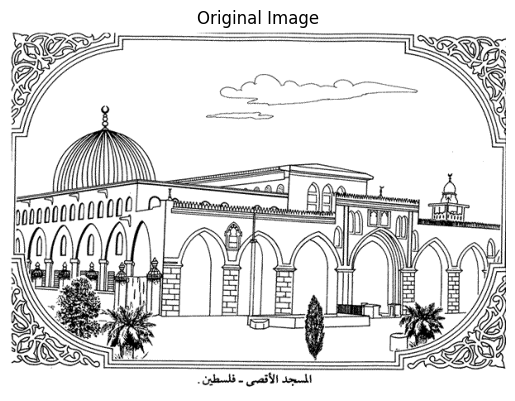

In [98]:
# Function to download an image from a URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Input the path or URL
image_input = input("Enter the path or URL to the image:(To use the Required Image 'Aqsa Image' u can use this url: https://www.familyholiday.net/wp-content/uploads/2012/07/ramadan-coloring-pages-for-kids_011.jpg) ")


# Determine if the input is a URL or a file path
if image_input.startswith('http://') or image_input.startswith('https://'):
    # It's a URL, download the image
    image = download_image(image_input)
else:
    # It's a file path, load the image from the file system
    if not os.path.isfile(image_input):
        raise FileNotFoundError(f"The file at path {image_input} does not exist.")
    image = Image.open(image_input)

# Convert to grayscale
image = image.convert("L")

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()


Loading an image from a URL or file path:

*   download_image downloads an image from a URL.
*   It then checks if the input is a URL or a file path, loads the image accordingly, converts it to grayscale, and displays it using matplotlib.
---


# Getting information From the user:

Asking the user to enter the Key, IV and then displaying the rusults:

Enter the key as four 32-bit hexadecimal numbers separated by spaces (e.g., 0x11223344 0x55667788 0x99AABBCC 0xDDEEFF00): 0x11223344 0x55667788 0x99AABBCC 0xDDEEFF00
Enter the IV as two 32-bit hexadecimal numbers separated by a space (e.g., 0xAABBCCDD 0xEEFF0011): 0xAABBCCDD 0xEEFF0011


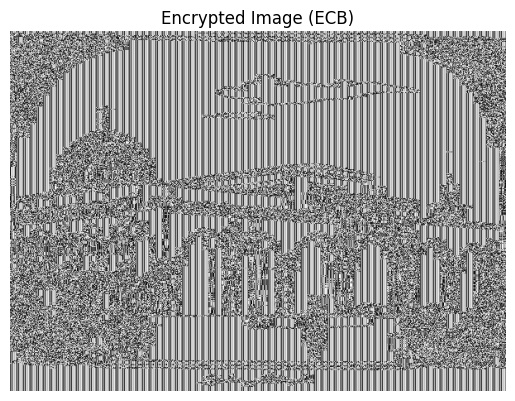

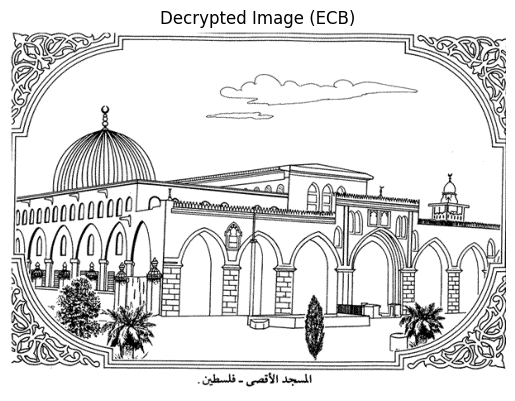

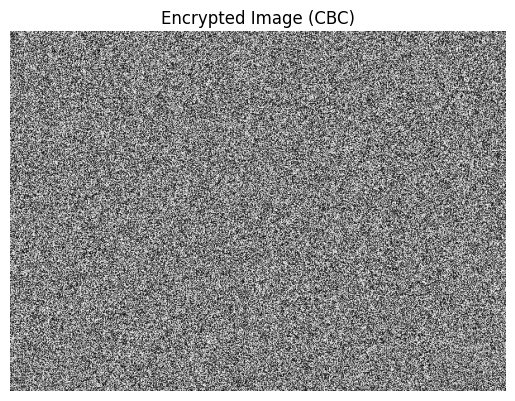

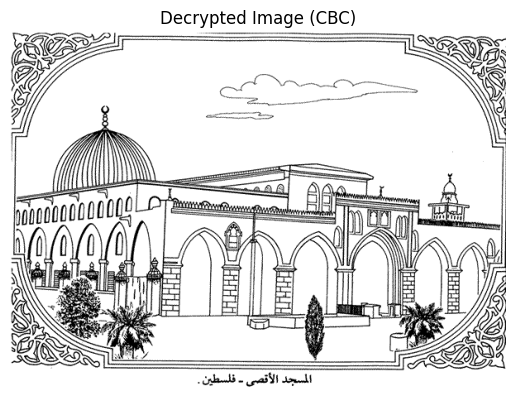

In [99]:
# Convert image to blocks
image_blocks, image_shape = image_to_blocks(image)

# Get user input for the key
key_input = input("Enter the key as four 32-bit hexadecimal numbers separated by spaces (e.g., 0x11223344 0x55667788 0x99AABBCC 0xDDEEFF00): ")
key = [int(x, 16) for x in key_input.split()]

# Get user input for the IV
iv_input = input("Enter the IV as two 32-bit hexadecimal numbers separated by a space (e.g., 0xAABBCCDD 0xEEFF0011): ")
iv = tuple(int(x, 16) for x in iv_input.split())

# Encrypt and Decrypt the Image Using ECB Mode
# Encrypt using ECB mode
ciphertext_blocks_ecb = encrypt_ecb(image_blocks, key)

# Display the encrypted image (ECB)
encrypted_image_ecb = blocks_to_image(ciphertext_blocks_ecb, image_shape)
plt.imshow(encrypted_image_ecb, cmap='gray')
plt.title("Encrypted Image (ECB)")
plt.axis('off')
plt.show()

# Decrypt using ECB mode
decrypted_blocks_ecb = decrypt_ecb(ciphertext_blocks_ecb, key)

# Convert blocks back to image
decrypted_image_ecb = blocks_to_image(decrypted_blocks_ecb, image_shape)

# Display the decrypted image
plt.imshow(decrypted_image_ecb, cmap='gray')
plt.title("Decrypted Image (ECB)")
plt.axis('off')
plt.show()

# Encrypt and Decrypt the Image Using CBC Mode
# Encrypt using CBC mode
ciphertext_blocks_cbc = encrypt_cbc(image_blocks, key, iv)

# Display the encrypted image (CBC)
encrypted_image_cbc = blocks_to_image(ciphertext_blocks_cbc, image_shape)
plt.imshow(encrypted_image_cbc, cmap='gray')
plt.title("Encrypted Image (CBC)")
plt.axis('off')
plt.show()

# Decrypt using CBC mode
decrypted_blocks_cbc = decrypt_cbc(ciphertext_blocks_cbc, key, iv)

# Convert blocks back to image
decrypted_image_cbc = blocks_to_image(decrypted_blocks_cbc, image_shape)

# Display the decrypted image
plt.imshow(decrypted_image_cbc, cmap='gray')
plt.title("Decrypted Image (CBC)")
plt.axis('off')
plt.show()


---
---
---